In [44]:
!pip install requests panda datetime matplotlib ipywidgets numpy mplfinance

In [162]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 11.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.1/39.1 MB 6.8 MB/s eta 0:00:0000:0100:01


In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc

class KlineDataFetcher:
    @staticmethod
    def fetch_data(base, quote, interval, start_date, end_date):
        base = base.upper()
        quote = quote.upper()
        symbol = f"{base}{quote}"
        
        url = "https://api.binance.com/api/v3/klines"
        limit = 1000  # Maximum number of klines per request

        start_date_ts = int(pd.to_datetime(start_date).timestamp() * 1000)
        end_date_ts = int(pd.to_datetime(end_date).timestamp() * 1000)

        all_data = []
        while start_date_ts < end_date_ts:
            params = {
                "symbol": symbol,
                "interval": interval,
                "startTime": start_date_ts,
                "endTime": end_date_ts,
                "limit": limit
            }

            response = requests.get(url, params=params)
            data = response.json()

            if not data:
                break

            all_data.extend(data)
            start_date_ts = data[-1][0] + 1  # Move to the next kline

            # If the number of klines returned is less than the limit, we've reached the end
            if len(data) < limit:
                break

        # Convert the data into a DataFrame
        df = pd.DataFrame(all_data, columns=[
            "timestamp", "open", "high", "low", "close", "volume", "close_time",
            "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume",
            "taker_buy_quote_asset_volume", "ignore"
        ])
        
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ms')
        
        # Optionally convert numeric columns to appropriate types
        numeric_columns = ["open", "high", "low", "close", "volume", "quote_asset_volume", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]
        df[numeric_columns] = df[numeric_columns].astype(float)
        
        return df

class KlinePlotter:
    @staticmethod
    def plot(df, title="Historical Price", xlabel="Date", ylabel="Price (USDT)", save_path=None):
        if df.empty:
            raise ValueError("No data available to plot.")

        plt.figure(figsize=(24, 6))
        plt.plot(df['timestamp'], df['close'], label='Close Price', color='black')

        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()


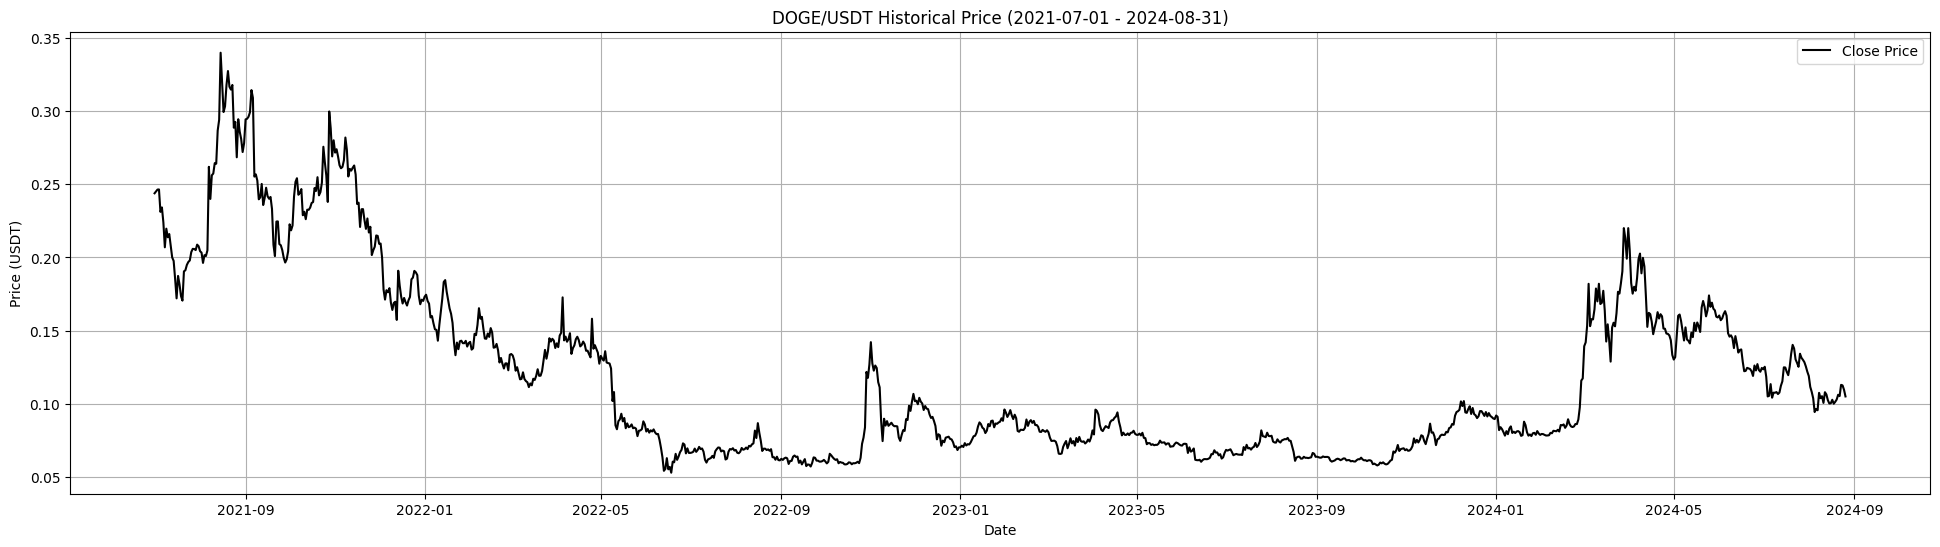

In [71]:
if __name__ == "__main__":
    base = "DOGE"
    quote = "USDT"
    interval = "1d"
    start_date = "2021-07-01"
    end_date = "2024-08-31"
    
    # Fetch data
    df = KlineDataFetcher.fetch_data(base, quote, interval, start_date, end_date)
    
    # Plot data
    KlinePlotter.plot(df, title=f"{base}/{quote} Historical Price ({start_date} - {end_date})")

In [125]:
import pandas as pd

def find_narrow_periods(df, bollinger_window, bollinger_threshold):
    df['MA'] = df['close'].rolling(bollinger_window).mean()
    df['STD'] = df['close'].rolling(bollinger_window).std()
    df['Upper_Band'] = df['MA'] + (df['STD'] * 2)
    df['Lower_Band'] = df['MA'] - (df['STD'] * 2)
    df['Bollinger_Narrow'] = (df['Upper_Band'] - df['Lower_Band']) / df['MA'] < bollinger_threshold
    
    narrow_periods = []
    in_narrow_period = False
    start_date = None

    for i in range(len(df)):
        if df['Bollinger_Narrow'].iloc[i] and not in_narrow_period:
            # Start of a new narrow period
            in_narrow_period = True
            start_date = df['timestamp'].iloc[i]
        elif not df['Bollinger_Narrow'].iloc[i] and in_narrow_period:
            # End of the narrow period
            in_narrow_period = False
            end_date = df['timestamp'].iloc[i]
            narrow_periods.append({"start": start_date, "end": end_date})
    
    # Handle case where the narrow period goes until the end of the data
    if in_narrow_period:
        narrow_periods.append({"start": start_date, "end": df['timestamp'].iloc[-1]})
    
    narrow_periods_df = pd.DataFrame(narrow_periods)
    return narrow_periods_df

# Example usage with your DataFrame `df`:
bollinger_window = 8
bollinger_threshold = 0.17

narrow_periods_df = find_narrow_periods(df, bollinger_window, bollinger_threshold)
narrow_periods_df


,start,end
0,2019-07-13,2019-07-14
1,2019-07-21,2019-08-17
2,2019-08-18,2019-09-18
3,2019-09-22,2019-09-24
4,2019-10-01,2019-10-16
...,...,...
79,2024-06-23,2024-07-04
80,2024-07-11,2024-07-15
81,2024-07-26,2024-08-02
82,2024-08-14,2024-08-24


In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    df['MA'] = df['close'].rolling(window).mean()
    df['STD'] = df['close'].rolling(window).std()
    df['Upper_Band'] = df['MA'] + (df['STD'] * num_std_dev)
    df['Lower_Band'] = df['MA'] - (df['STD'] * num_std_dev)

def calculate_adx(df, window=14):
    df['TR'] = np.maximum(df['high'] - df['low'], np.abs(df['high'] - df['close'].shift(1)), np.abs(df['low'] - df['close'].shift(1)))
    df['+DM'] = np.where((df['high'] - df['high'].shift(1)) > (df['low'].shift(1) - df['low']), np.maximum(df['high'] - df['high'].shift(1), 0), 0)
    df['-DM'] = np.where((df['low'].shift(1) - df['low']) > (df['high'] - df['high'].shift(1)), np.maximum(df['low'].shift(1) - df['low'], 0), 0)

    df['+DI'] = 100 * (df['+DM'].rolling(window).mean() / df['TR'].rolling(window).mean())
    df['-DI'] = 100 * (df['-DM'].rolling(window).mean() / df['TR'].rolling(window).mean())
    df['DX'] = 100 * np.abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = df['DX'].rolling(window).mean()

def calculate_atr(df, window=14):
    df['TR'] = np.maximum(df['high'] - df['low'], np.abs(df['high'] - df['close'].shift(1)), np.abs(df['low'] - df['close'].shift(1)))
    df['ATR'] = df['TR'].rolling(window).mean()

def plot_with_bollinger_adx_atr(df, window=20, num_std_dev=2, adx_window=14, atr_window=14):
    # Calculate Bollinger Bands, ADX, and ATR
    calculate_bollinger_bands(df, window, num_std_dev)
    calculate_adx(df, adx_window)
    calculate_atr(df, atr_window)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 12), sharex=True)

    # Plot Closing Price with Bollinger Bands
    ax1.plot(df['timestamp'], df['close'], label='Close Price', color='black')
    ax1.plot(df['timestamp'], df['Upper_Band'], label='Upper Bollinger Band', linestyle='--', color='blue')
    ax1.plot(df['timestamp'], df['Lower_Band'], label='Lower Bollinger Band', linestyle='--', color='blue')

    # Highlight sideways markets where the bands are close together
    is_sideways = (df['Upper_Band'] - df['Lower_Band']) / df['MA'] < 0.05  # Adjust threshold as needed
    ax1.fill_between(df['timestamp'], df['Lower_Band'], df['Upper_Band'], where=is_sideways, color='blue', alpha=0.2)

    ax1.set_title(f"Price with Bollinger Bands ({window}-day window, {num_std_dev} std dev)")
    ax1.set_ylabel("Price (USDT)")
    ax1.legend()
    ax1.grid(True)

    # Plot ADX
    ax2.plot(df['timestamp'], df['ADX'], label='ADX', color='green')
    ax2.axhline(y=25, color='red', linestyle='--', label='Weak Trend Threshold')
    ax2.set_title(f"ADX (Average Directional Index, {adx_window}-day window)")
    ax2.set_ylabel("ADX Value")
    ax2.legend()
    ax2.grid(True)

    # Plot ATR
    ax3.plot(df['timestamp'], df['ATR'], label='ATR', color='purple')
    ax3.set_title(f"ATR (Average True Range, {atr_window}-day window)")
    ax3.set_ylabel("ATR Value")
    ax3.set_xlabel("Date")
    ax3.legend()
    ax3.grid(True)

    plt.show()

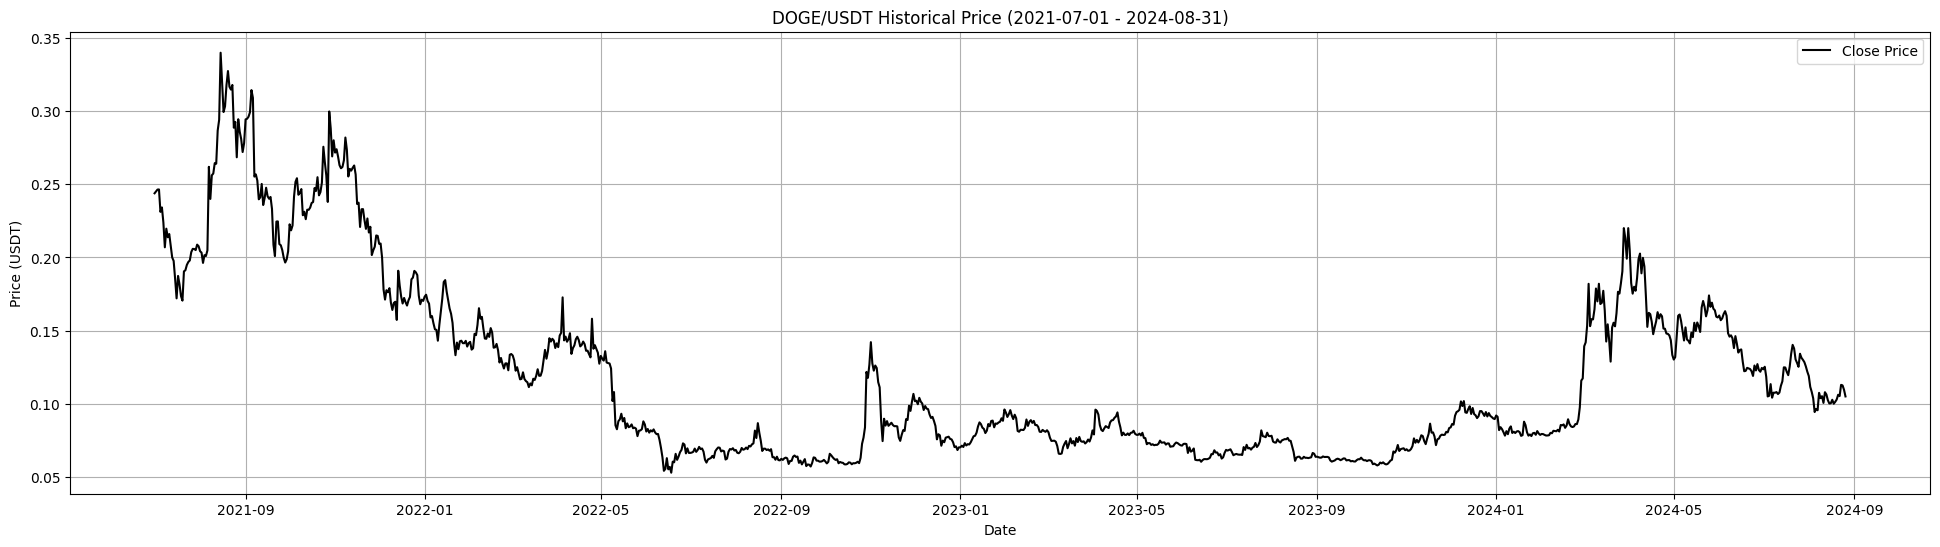

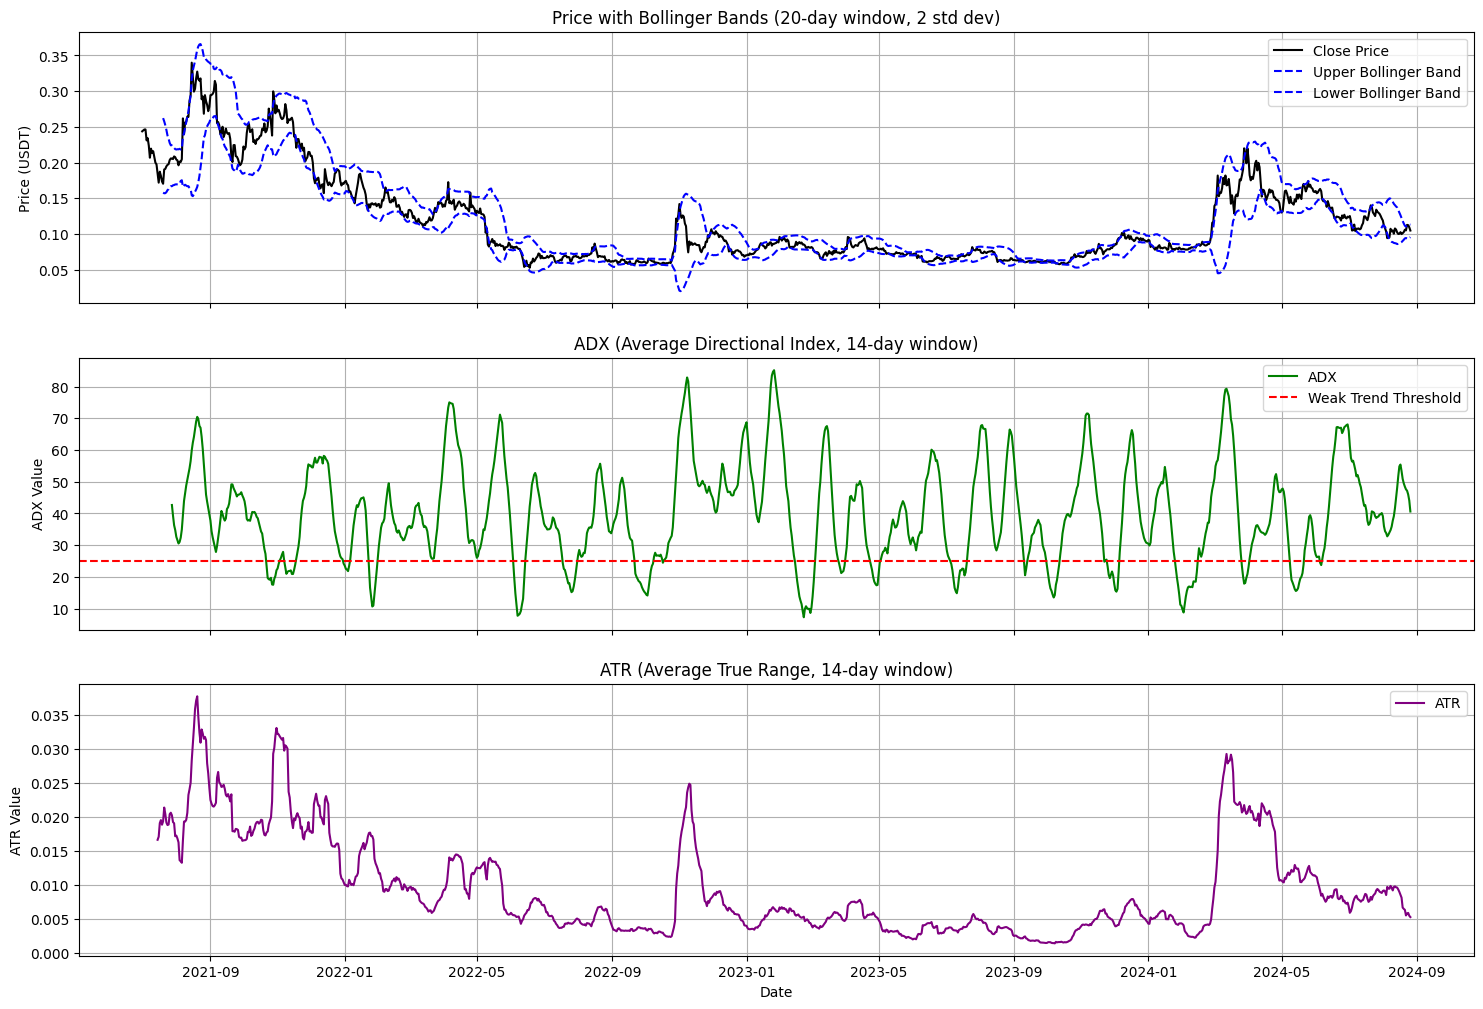

In [73]:
if __name__ == "__main__":
    base = "DOGE"
    quote = "USDT"
    interval = "1d"
    start_date = "2021-07-01"
    end_date = "2024-08-31"
    
    # Fetch data
    df = KlineDataFetcher.fetch_data(base, quote, interval, start_date, end_date)
    
    # Plot data
    KlinePlotter.plot(df, title=f"{base}/{quote} Historical Price ({start_date} - {end_date})")
    
    # Plot the closing prices with Bollinger Bands, ADX, and ATR
    plot_with_bollinger_adx_atr(df, window=20, num_std_dev=2, adx_window=14, atr_window=14)

In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def ensure_numeric_columns(df):
    """
    Ensure that the relevant columns in the DataFrame are numeric.
    
    Parameters:
    - df: pandas DataFrame containing the market data.
    
    Returns:
    - The DataFrame with the 'high', 'low', 'close', and other necessary columns converted to numeric types.
    """
    df['high'] = pd.to_numeric(df['high'], errors='coerce')
    df['low'] = pd.to_numeric(df['low'], errors='coerce')
    df['close'] = pd.to_numeric(df['close'], errors='coerce')
    df['open'] = pd.to_numeric(df['open'], errors='coerce')
    return df

def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    df['MA'] = df['close'].rolling(window).mean()
    df['STD'] = df['close'].rolling(window).std()
    df['Upper_Band'] = df['MA'] + (df['STD'] * num_std_dev)
    df['Lower_Band'] = df['MA'] - (df['STD'] * num_std_dev)

def calculate_adx(df, window=14):
    df['TR'] = np.maximum(df['high'] - df['low'], np.abs(df['high'] - df['close'].shift(1)), np.abs(df['low'] - df['close'].shift(1)))
    df['+DM'] = np.where((df['high'] - df['high'].shift(1)) > (df['low'].shift(1) - df['low']), np.maximum(df['high'] - df['high'].shift(1), 0), 0)
    df['-DM'] = np.where((df['low'].shift(1) - df['low']) > (df['high'] - df['high'].shift(1)), np.maximum(df['low'].shift(1) - df['low'], 0), 0)

    df['+DI'] = 100 * (df['+DM'].rolling(window).mean() / df['TR'].rolling(window).mean())
    df['-DI'] = 100 * (df['-DM'].rolling(window).mean() / df['TR'].rolling(window).mean())
    df['DX'] = 100 * np.abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = df['DX'].rolling(window).mean()

def calculate_atr(df, window=14):
    df['TR'] = np.maximum(df['high'] - df['low'], np.abs(df['high'] - df['close'].shift(1)), np.abs(df['low'] - df['close'].shift(1)))
    df['ATR'] = df['TR'].rolling(window).mean()

def detect_sideways_market(df, adx_threshold=25, atr_threshold=0.02, bollinger_threshold=0.05):
    # Ensure columns are numeric
    df = ensure_numeric_columns(df)
    
    # Calculate if Bollinger Bands are narrow
    df['Bollinger_Narrow'] = (df['Upper_Band'] - df['Lower_Band']) / df['MA'] < bollinger_threshold

    # Identify sideways market periods
    df['Sideways_Market'] = (df['ADX'] < adx_threshold) & (df['ATR'] < atr_threshold) & df['Bollinger_Narrow']
    
    return df

def plot_with_sideways_market_detection(df, window=20, num_std_dev=2, adx_window=14, atr_window=14, adx_threshold=25, atr_threshold=0.02, bollinger_threshold=0.05):
    # Ensure columns are numeric before any calculations
    df = ensure_numeric_columns(df)
    
    # Calculate Bollinger Bands, ADX, and ATR
    calculate_bollinger_bands(df, window, num_std_dev)
    calculate_adx(df, adx_window)
    calculate_atr(df, atr_window)
    
    # Detect sideways market periods
    df = detect_sideways_market(df, adx_threshold, atr_threshold, bollinger_threshold)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 12), sharex=True)

    # Plot Closing Price with Bollinger Bands and highlight sideways market periods
    ax1.plot(df['timestamp'], df['close'], label='Close Price', color='black')
    ax1.plot(df['timestamp'], df['Upper_Band'], label='Upper Bollinger Band', linestyle='--', color='blue')
    ax1.plot(df['timestamp'], df['Lower_Band'], label='Lower Bollinger Band', linestyle='--', color='blue')
    ax1.fill_between(df['timestamp'], df['Lower_Band'], df['Upper_Band'], where=df['Sideways_Market'], color='yellow', alpha=0.3)

    ax1.set_title(f"Price with Bollinger Bands and Sideways Market Detection ({window}-day window, {num_std_dev} std dev)")
    ax1.set_ylabel("Price (USDT)")
    ax1.legend()
    ax1.grid(True)

    # Plot ADX
    ax2.plot(df['timestamp'], df['ADX'], label='ADX', color='green')
    ax2.axhline(y=adx_threshold, color='red', linestyle='--', label='Weak Trend Threshold')
    ax2.set_title(f"ADX (Average Directional Index, {adx_window}-day window)")
    ax2.set_ylabel("ADX Value")
    ax2.legend()
    ax2.grid(True)

    # Plot ATR
    ax3.plot(df['timestamp'], df['ATR'], label='ATR', color='purple')
    ax3.axhline(y=atr_threshold, color='orange', linestyle='--', label='Low Volatility Threshold')
    ax3.set_title(f"ATR (Average True Range, {atr_window}-day window)")
    ax3.set_ylabel("ATR Value")
    ax3.set_xlabel("Date")
    ax3.legend()
    ax3.grid(True)

    plt.show()


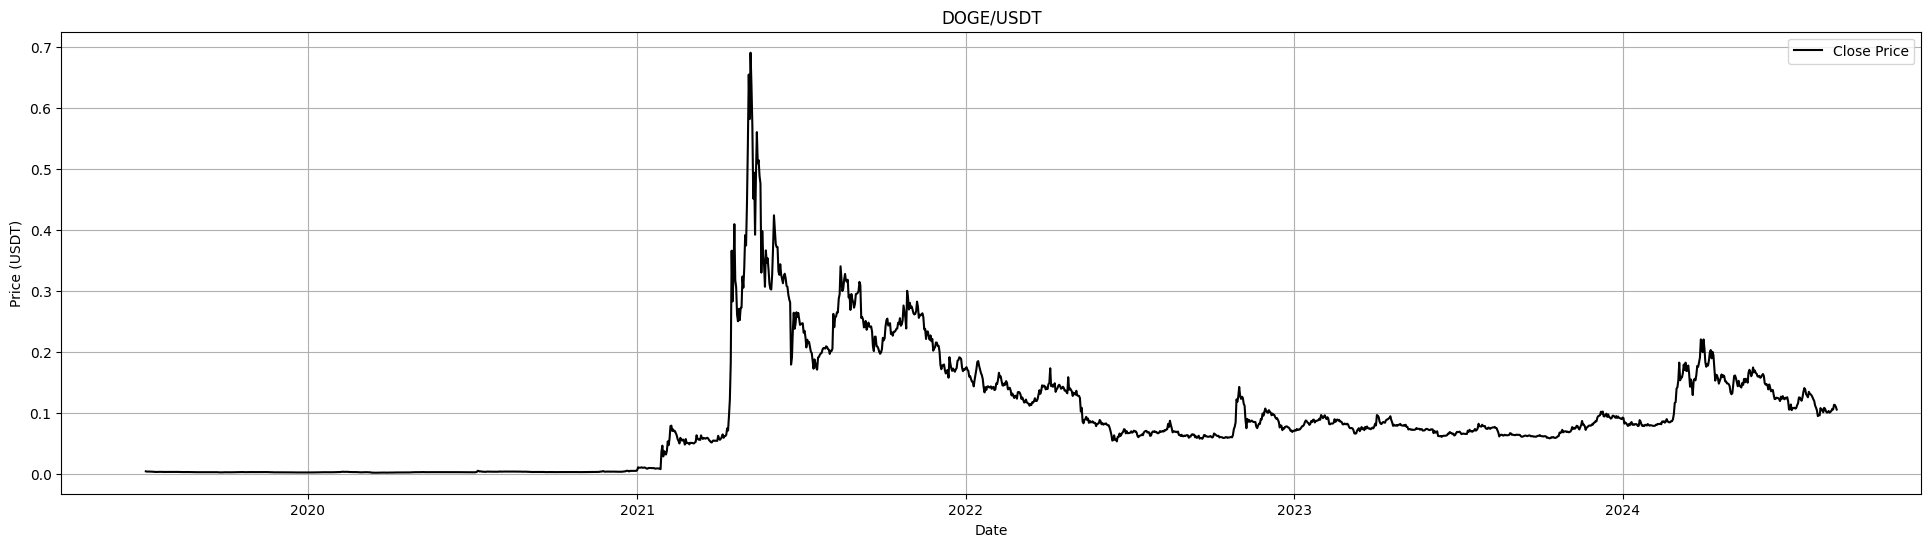

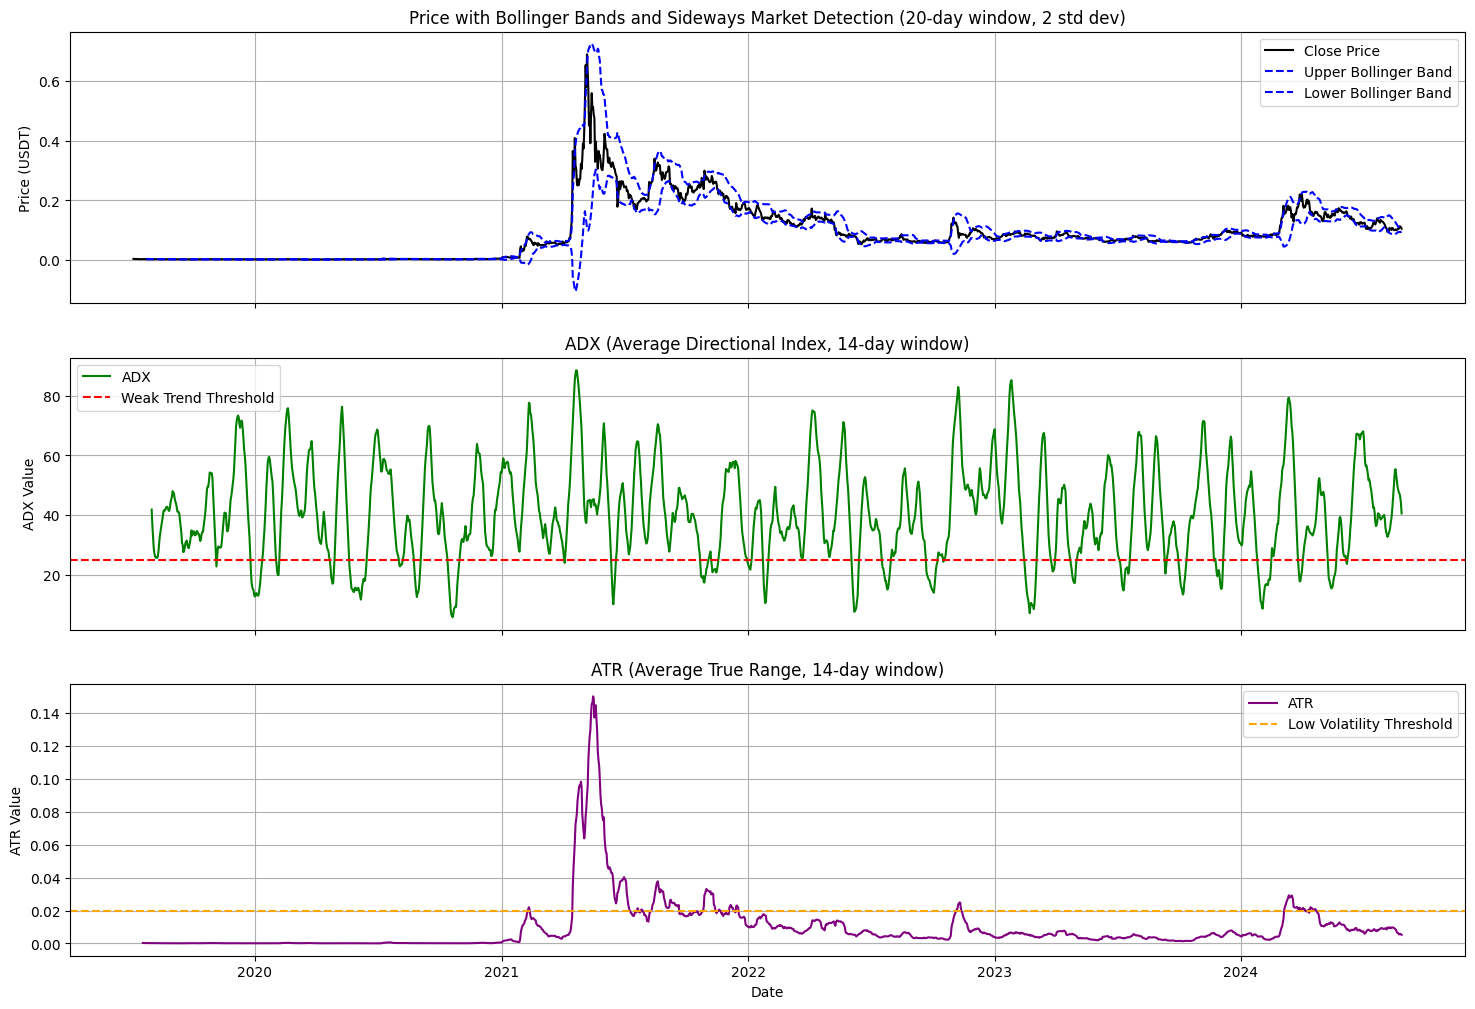

In [75]:

# Fetch data for DOGE/USDT
df = KlineDataFetcher.fetch_data(base="DOGE", quote="USDT", interval="1d", start_date="2019-01-01", end_date="2024-08-31")

# Plot the Kline data
ax = KlinePlotter.plot(df, title="DOGE/USDT")

# Use the function as usual after gathering your data into a DataFrame 'df'
plot_with_sideways_market_detection(df, window=20, num_std_dev=2, adx_window=14, atr_window=14, adx_threshold=25, atr_threshold=0.02, bollinger_threshold=0.05)

In [126]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive_output, VBox, HBox
from matplotlib.dates import DateFormatter, DayLocator

# Theme definitions with further adjustments
themes = {
    "default": {
        "price_color": "#aaaaaa",  # Slightly darker grey for the price line
        "price_linewidth": 1,  # Keep the price line thin
        "upper_band_color": "#007acc",  # Blue for the upper band (darker for better visibility)
        "lower_band_color": "#cc6600",  # Orange for the lower band (darker for better visibility)
        "band_linewidth": 1,  # Slightly thicker lines for the Bollinger Bands
        "band_alpha": 0.7,  # Reduced transparency for the bands
        "threshold_fill_color": "#ffcc00",  # Yellow for the threshold fill (to stand out)
        "threshold_fill_alpha": 0.8,  # More opaque fill to emphasize narrow zones
        "grid_color": "#e0e0e0",  # Light grey for grid lines to reduce distraction
        "grid_linewidth": 0.5  # Thinner grid lines
    }
}

def calculate_dynamic_interval(start_date, end_date):
    years_difference = end_date.year - start_date.year
    base_interval = 7
    dynamic_interval = base_interval + (years_difference * 7)
    return dynamic_interval

def move_start_date_two_years_back(df, end_date):
    try:
        two_years_ago = end_date - pd.DateOffset(years=2)
        if df['timestamp'].min() <= two_years_ago:
            return two_years_ago
        else:
            return df['timestamp'].min()
    except Exception:
        return df['timestamp'].min()

def interactive_bollinger_plot(df, selected_theme="default"):
    # Apply the chosen theme
    theme = themes[selected_theme]

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    end_date = pd.to_datetime(df['timestamp'].max())
    start_date = move_start_date_two_years_back(df, end_date)

    # Theme dropdown
    theme_dropdown = widgets.Dropdown(
        options=themes.keys(),
        value=selected_theme,
        description='Theme',
        layout=widgets.Layout(width='80%')
    )

    start_date_slider = widgets.SelectionSlider(
        options=pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%d').unique(),
        value=start_date.strftime('%Y-%m-%d'),
        description='Start Date',
        layout=widgets.Layout(width='80%')
    )

    end_date_slider = widgets.SelectionSlider(
        options=pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%d').unique(),
        value=end_date.strftime('%Y-%m-%d'),
        description='End Date',
        layout=widgets.Layout(width='80%')
    )

    bollinger_window_slider = widgets.IntSlider(
        min=5, max=50, step=1, value=8, description='Bollinger Window', layout=widgets.Layout(width='80%')
    )

    bollinger_threshold_slider = widgets.FloatSlider(
        min=0.01, max=1.0, step=0.01, value=0.17, description='Bollinger Threshold', layout=widgets.Layout(width='80%')
    )

    plot_width_slider = widgets.FloatSlider(
        min=6, max=24, step=1, value=18, description='Plot Width', layout=widgets.Layout(width='80%')
    )

    plot_height_slider = widgets.FloatSlider(
        min=3, max=10, step=0.5, value=4.5, description='Plot Height', layout=widgets.Layout(width='80%')
    )

    def update_threshold_visibility(*args):
        if bollinger_window_slider.value > 20:  # Example threshold value
            bollinger_threshold_slider.layout.display = 'none'
        else:
            bollinger_threshold_slider.layout.display = 'flex'

    bollinger_window_slider.observe(update_threshold_visibility, 'value')

    def plot_bollinger_bands_interactive(start_date, end_date, bollinger_window, bollinger_threshold, plot_width, plot_height, theme_dropdown):
        # Apply the chosen theme
        theme = themes[theme_dropdown]
        
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        daylocator_interval = calculate_dynamic_interval(start_date, end_date)

        mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
        df_filtered = df.loc[mask].copy()

        df_filtered['MA'] = df_filtered['close'].rolling(bollinger_window).mean()
        df_filtered['STD'] = df_filtered['close'].rolling(bollinger_window).std()
        df_filtered['Upper_Band'] = df_filtered['MA'] + (df_filtered['STD'] * 2)
        df_filtered['Lower_Band'] = df_filtered['MA'] - (df_filtered['STD'] * 2)
        df_filtered['Bollinger_Narrow'] = (df_filtered['Upper_Band'] - df_filtered['Lower_Band']) / df_filtered['MA'] < bollinger_threshold

        fig, ax = plt.subplots(figsize=(plot_width, plot_height))
        
        ax.plot(df_filtered['timestamp'], df_filtered['close'], 
                label='Close Price', 
                color=theme["price_color"], 
                linewidth=theme["price_linewidth"])

        ax.plot(df_filtered['timestamp'], df_filtered['Upper_Band'], 
                label='Upper Bollinger Band', 
                linestyle='-', 
                color=theme["upper_band_color"], 
                linewidth=theme["band_linewidth"],
                alpha=theme["band_alpha"])
        
        ax.plot(df_filtered['timestamp'], df_filtered['Lower_Band'], 
                label='Lower Bollinger Band', 
                linestyle='-', 
                color=theme["lower_band_color"], 
                linewidth=theme["band_linewidth"],
                alpha=theme["band_alpha"])
        
        ax.fill_between(df_filtered['timestamp'], df_filtered['Lower_Band'], df_filtered['Upper_Band'], 
                        where=df_filtered['Bollinger_Narrow'], 
                        color=theme["threshold_fill_color"], 
                        alpha=theme["threshold_fill_alpha"])
        
        ax.set_title(f"Bollinger Bands ({bollinger_window}-day window)")
        ax.set_ylabel("Price (USDT)")
        ax.legend()
        ax.grid(True, color=theme["grid_color"], linewidth=theme["grid_linewidth"])

        # Adjust visibility of date labels
        date_colors = ['black' if narrow else '#cccccc' for narrow in df_filtered['Bollinger_Narrow']]
        locator = DayLocator(interval=daylocator_interval)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
        fig.autofmt_xdate(rotation=90)  # Rotate labels to 90 degrees

        for tick, color in zip(ax.get_xticklabels(), date_colors):
            tick.set_color(color)
        
        plt.show()

    # Trigger the visibility update initially
    update_threshold_visibility()

    out = interactive_output(
        plot_bollinger_bands_interactive,
        {
            'start_date': start_date_slider,
            'end_date': end_date_slider,
            'bollinger_window': bollinger_window_slider,
            'bollinger_threshold': bollinger_threshold_slider,
            'plot_width': plot_width_slider,
            'plot_height': plot_height_slider,
            'theme_dropdown': theme_dropdown
        }
    )

    ui = VBox([
        theme_dropdown,
        HBox([start_date_slider, end_date_slider]),
        HBox([bollinger_window_slider, bollinger_threshold_slider]),
        HBox([plot_width_slider, plot_height_slider]),
        out
    ])
    
    display(ui)

# Usage Example: 
# df = <your dataframe>
interactive_bollinger_plot(df)


In [138]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive_output, VBox, HBox, Output
from matplotlib.dates import DateFormatter, DayLocator

themes = {
    "default": {
        "price_color": "#aaaaaa",
        "price_linewidth": 1,
        "upper_band_color": "#007acc",
        "lower_band_color": "#cc6600",
        "band_linewidth": 1,
        "band_alpha": 0.7,
        "threshold_fill_color": "#ffcc00",
        "threshold_fill_alpha": 0.8,
        "grid_color": "#e0e0e0",
        "grid_linewidth": 0.5
    }
}

def calculate_dynamic_interval(start_date, end_date):
    years_difference = end_date.year - start_date.year
    base_interval = 7
    dynamic_interval = base_interval + (years_difference * 7)
    return dynamic_interval

def move_start_date_two_years_back(df, end_date):
    try:
        two_years_ago = end_date - pd.DateOffset(years=2)
        if df['timestamp'].min() <= two_years_ago:
            return two_years_ago
        else:
            return df['timestamp'].min()
    except Exception:
        return df['timestamp'].min()

def find_narrow_periods(df, bollinger_window, bollinger_threshold):
    df['MA'] = df['close'].rolling(bollinger_window).mean()
    df['STD'] = df['close'].rolling(bollinger_window).std()
    df['Upper_Band'] = df['MA'] + (df['STD'] * 2)
    df['Lower_Band'] = df['MA'] - (df['STD'] * 2)
    df['Bollinger_Narrow'] = (df['Upper_Band'] - df['Lower_Band']) / df['MA'] < bollinger_threshold
    
    narrow_periods = []
    in_narrow_period = False
    start_date = None

    for i in range(len(df)):
        if df['Bollinger_Narrow'].iloc[i] and not in_narrow_period:
            in_narrow_period = True
            start_date = df['timestamp'].iloc[i]
        elif not df['Bollinger_Narrow'].iloc[i] and in_narrow_period:
            in_narrow_period = False
            end_date = df['timestamp'].iloc[i]
            duration = end_date - start_date
            narrow_periods.append({
                "start": start_date, 
                "end": end_date,
                "duration_days": duration.days,
                "duration_hours": duration.total_seconds() / 3600,
                "duration_minutes": duration.total_seconds() / 60
            })
    
    if in_narrow_period:
        end_date = df['timestamp'].iloc[-1]
        duration = end_date - start_date
        narrow_periods.append({
            "start": start_date, 
            "end": end_date,
            "duration_days": duration.days,
            "duration_hours": duration.total_seconds() / 3600,
            "duration_minutes": duration.total_seconds() / 60
        })
    
    narrow_periods_df = pd.DataFrame(narrow_periods)
    return narrow_periods_df

def interactive_bollinger_plot(df, selected_theme="default"):
    theme = themes[selected_theme]

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    end_date = pd.to_datetime(df['timestamp'].max())
    start_date = move_start_date_two_years_back(df, end_date)

    start_date_slider = widgets.SelectionSlider(
        options=pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%d').unique(),
        value=start_date.strftime('%Y-%m-%d'),
        description='Start Date',
        layout=widgets.Layout(width='80%')
    )

    end_date_slider = widgets.SelectionSlider(
        options=pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%d').unique(),
        value=end_date.strftime('%Y-%m-%d'),
        description='End Date',
        layout=widgets.Layout(width='80%')
    )

    bollinger_window_slider = widgets.IntSlider(
        min=5, max=50, step=1, value=8, description='Bollinger Window', layout=widgets.Layout(width='80%')
    )

    bollinger_threshold_slider = widgets.FloatSlider(
        min=0.01, max=1.0, step=0.01, value=0.17, description='Bollinger Threshold', layout=widgets.Layout(width='80%')
    )

    plot_width_slider = widgets.FloatSlider(
        min=6, max=24, step=1, value=18, description='Plot Width', layout=widgets.Layout(width='80%')
    )

    plot_height_slider = widgets.FloatSlider(
        min=3, max=10, step=0.5, value=4.5, description='Plot Height', layout=widgets.Layout(width='80%')
    )

    output_table = Output()

    def plot_bollinger_bands_interactive(start_date, end_date, bollinger_window, bollinger_threshold, plot_width, plot_height):
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        daylocator_interval = calculate_dynamic_interval(start_date, end_date)

        mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
        df_filtered = df.loc[mask].copy()

        df_filtered['MA'] = df_filtered['close'].rolling(bollinger_window).mean()
        df_filtered['STD'] = df_filtered['close'].rolling(bollinger_window).std()
        df_filtered['Upper_Band'] = df_filtered['MA'] + (df_filtered['STD'] * 2)
        df_filtered['Lower_Band'] = df_filtered['MA'] - (df_filtered['STD'] * 2)
        df_filtered['Bollinger_Narrow'] = (df_filtered['Upper_Band'] - df_filtered['Lower_Band']) / df_filtered['MA'] < bollinger_threshold

        fig, ax = plt.subplots(figsize=(plot_width, plot_height))
        
        ax.plot(df_filtered['timestamp'], df_filtered['close'], 
                color=theme["price_color"], 
                linewidth=theme["price_linewidth"])

        ax.plot(df_filtered['timestamp'], df_filtered['Upper_Band'], 
                linestyle='-', 
                color=theme["upper_band_color"], 
                linewidth=theme["band_linewidth"],
                alpha=theme["band_alpha"])
        
        ax.plot(df_filtered['timestamp'], df_filtered['Lower_Band'], 
                linestyle='-', 
                color=theme["lower_band_color"], 
                linewidth=theme["band_linewidth"],
                alpha=theme["band_alpha"])
        
        ax.fill_between(df_filtered['timestamp'], df_filtered['Lower_Band'], df_filtered['Upper_Band'], 
                        where=df_filtered['Bollinger_Narrow'], 
                        color=theme["threshold_fill_color"], 
                        alpha=theme["threshold_fill_alpha"])
        
        ax.xaxis.set_major_locator(DayLocator(interval=daylocator_interval))
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
        fig.autofmt_xdate(rotation=90)

        ax.axis('off')  # Turn off axis lines and labels

        plt.show()

        narrow_periods_df = find_narrow_periods(df_filtered, bollinger_window, bollinger_threshold)
        
        with output_table:
            output_table.clear_output(wait=True)
            display(narrow_periods_df)
        
        return narrow_periods_df

    out = interactive_output(
        plot_bollinger_bands_interactive,
        {
            'start_date': start_date_slider,
            'end_date': end_date_slider,
            'bollinger_window': bollinger_window_slider,
            'bollinger_threshold': bollinger_threshold_slider,
            'plot_width': plot_width_slider,
            'plot_height': plot_height_slider
        }
    )

    ui = VBox([
        HBox([start_date_slider, end_date_slider]),
        HBox([bollinger_window_slider, bollinger_threshold_slider]),
        HBox([plot_width_slider, plot_height_slider]),
        out,
        output_table
    ])
    
    display(ui)

    return find_narrow_periods(df, bollinger_window_slider.value, bollinger_threshold_slider.value)

# Assuming you have your DataFrame 'df' already prepared
narrow_periods_df = interactive_bollinger_plot(df)

# `narrow_periods_df` now contains the periods where the Bollinger Bands were narrow, along with their durations.


In [140]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive_output, VBox, HBox, Output
from matplotlib.dates import DateFormatter, DayLocator

themes = {
    "default": {
        "price_color": "#aaaaaa",
        "price_linewidth": 1,
        "upper_band_color": "#007acc",
        "lower_band_color": "#cc6600",
        "band_linewidth": 1,
        "band_alpha": 0.7,
        "threshold_fill_color": "#ffcc00",
        "threshold_fill_alpha": 0.8,
        "grid_color": "#e0e0e0",
        "grid_linewidth": 0.5
    }
}

def calculate_dynamic_interval(start_date, end_date):
    years_difference = end_date.year - start_date.year
    base_interval = 7
    dynamic_interval = base_interval + (years_difference * 7)
    return dynamic_interval

def move_start_date_two_years_back(df, end_date):
    try:
        two_years_ago = end_date - pd.DateOffset(years=2)
        if df['timestamp'].min() <= two_years_ago:
            return two_years_ago
        else:
            return df['timestamp'].min()
    except Exception:
        return df['timestamp'].min()

def find_narrow_periods(df, bollinger_window, bollinger_threshold, min_duration_days):
    df['MA'] = df['close'].rolling(bollinger_window).mean()
    df['STD'] = df['close'].rolling(bollinger_window).std()
    df['Upper_Band'] = df['MA'] + (df['STD'] * 2)
    df['Lower_Band'] = df['MA'] - (df['STD'] * 2)
    df['Bollinger_Narrow'] = (df['Upper_Band'] - df['Lower_Band']) / df['MA'] < bollinger_threshold
    
    narrow_periods = []
    in_narrow_period = False
    start_date = None

    for i in range(len(df)):
        if df['Bollinger_Narrow'].iloc[i] and not in_narrow_period:
            in_narrow_period = True
            start_date = df['timestamp'].iloc[i]
        elif not df['Bollinger_Narrow'].iloc[i] and in_narrow_period:
            in_narrow_period = False
            end_date = df['timestamp'].iloc[i]
            duration = end_date - start_date
            if duration.days >= min_duration_days:
                period_data = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]
                narrow_periods.append({
                    "start": start_date, 
                    "end": end_date,
                    "duration_days": duration.days,
                    "duration_hours": duration.total_seconds() / 3600,
                    "duration_minutes": duration.total_seconds() / 60,
                    "open": period_data['open'].iloc[0],
                    "high": period_data['high'].max(),
                    "low": period_data['low'].min(),
                    "close": period_data['close'].iloc[-1]
                })
    
    if in_narrow_period:
        end_date = df['timestamp'].iloc[-1]
        duration = end_date - start_date
        if duration.days >= min_duration_days:
            period_data = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]
            narrow_periods.append({
                "start": start_date, 
                "end": end_date,
                "duration_days": duration.days,
                "duration_hours": duration.total_seconds() / 3600,
                "duration_minutes": duration.total_seconds() / 60,
                "open": period_data['open'].iloc[0],
                "high": period_data['high'].max(),
                "low": period_data['low'].min(),
                "close": period_data['close'].iloc[-1]
            })
    
    narrow_periods_df = pd.DataFrame(narrow_periods)
    return narrow_periods_df

def interactive_bollinger_plot(df, selected_theme="default"):
    theme = themes[selected_theme]

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    end_date = pd.to_datetime(df['timestamp'].max())
    start_date = move_start_date_two_years_back(df, end_date)

    start_date_slider = widgets.SelectionSlider(
        options=pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%d').unique(),
        value=start_date.strftime('%Y-%m-%d'),
        description='Start Date',
        layout=widgets.Layout(width='80%')
    )

    end_date_slider = widgets.SelectionSlider(
        options=pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%d').unique(),
        value=end_date.strftime('%Y-%m-%d'),
        description='End Date',
        layout=widgets.Layout(width='80%')
    )

    bollinger_window_slider = widgets.IntSlider(
        min=5, max=50, step=1, value=10, description='Bollinger Window', layout=widgets.Layout(width='80%')
    )

    bollinger_threshold_slider = widgets.FloatSlider(
        min=0.01, max=1.0, step=0.01, value=0.17, description='Bollinger Threshold', layout=widgets.Layout(width='80%')
    )

    plot_width_slider = widgets.FloatSlider(
        min=6, max=24, step=1, value=18, description='Plot Width', layout=widgets.Layout(width='80%')
    )

    plot_height_slider = widgets.FloatSlider(
        min=3, max=10, step=0.5, value=3.5, description='Plot Height', layout=widgets.Layout(width='80%')
    )

    min_duration_days_slider = widgets.IntSlider(
        min=0, max=365, step=1, value=15, description='Min Duration (days)', layout=widgets.Layout(width='80%')
    )

    output_table = Output()

    def plot_bollinger_bands_interactive(start_date, end_date, bollinger_window, bollinger_threshold, plot_width, plot_height, min_duration_days):
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        daylocator_interval = calculate_dynamic_interval(start_date, end_date)

        mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
        df_filtered = df.loc[mask].copy()

        df_filtered['MA'] = df_filtered['close'].rolling(bollinger_window).mean()
        df_filtered['STD'] = df_filtered['close'].rolling(bollinger_window).std()
        df_filtered['Upper_Band'] = df_filtered['MA'] + (df_filtered['STD'] * 2)
        df_filtered['Lower_Band'] = df_filtered['MA'] - (df_filtered['STD'] * 2)
        df_filtered['Bollinger_Narrow'] = (df_filtered['Upper_Band'] - df_filtered['Lower_Band']) / df_filtered['MA'] < bollinger_threshold

        fig, ax = plt.subplots(figsize=(plot_width, plot_height))
        
        ax.plot(df_filtered['timestamp'], df_filtered['close'], 
                color=theme["price_color"], 
                linewidth=theme["price_linewidth"])

        ax.plot(df_filtered['timestamp'], df_filtered['Upper_Band'], 
                linestyle='-', 
                color=theme["upper_band_color"], 
                linewidth=theme["band_linewidth"],
                alpha=theme["band_alpha"])
        
        ax.plot(df_filtered['timestamp'], df_filtered['Lower_Band'], 
                linestyle='-', 
                color=theme["lower_band_color"], 
                linewidth=theme["band_linewidth"],
                alpha=theme["band_alpha"])
        
        ax.fill_between(df_filtered['timestamp'], df_filtered['Lower_Band'], df_filtered['Upper_Band'], 
                        where=df_filtered['Bollinger_Narrow'], 
                        color=theme["threshold_fill_color"], 
                        alpha=theme["threshold_fill_alpha"])
        
        ax.xaxis.set_major_locator(DayLocator(interval=daylocator_interval))
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
        fig.autofmt_xdate(rotation=90)

        plt.show()

        narrow_periods_df = find_narrow_periods(df_filtered, bollinger_window, bollinger_threshold, min_duration_days)
        
        with output_table:
            output_table.clear_output(wait=True)
            display(narrow_periods_df)
        
        return narrow_periods_df

    out = interactive_output(
        plot_bollinger_bands_interactive,
        {
            'start_date': start_date_slider,
            'end_date': end_date_slider,
            'bollinger_window': bollinger_window_slider,
            'bollinger_threshold': bollinger_threshold_slider,
            'plot_width': plot_width_slider,
            'plot_height': plot_height_slider,
            'min_duration_days': min_duration_days_slider
        }
    )

    ui = VBox([
        HBox([start_date_slider, end_date_slider]),
        HBox([bollinger_window_slider, bollinger_threshold_slider]),
        HBox([min_duration_days_slider]),
        HBox([plot_width_slider, plot_height_slider]),
        out,
        output_table
    ])
    
    display(ui)

# Usage Example: 
# df = <your dataframe>
interactive_bollinger_plot(df)

In [142]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive_output, VBox, HBox, Output
from matplotlib.dates import DateFormatter, DayLocator

themes = {
    "default": {
        "price_color": "#aaaaaa",
        "price_linewidth": 1,
        "upper_band_color": "#007acc",
        "lower_band_color": "#cc6600",
        "band_linewidth": 1,
        "band_alpha": 0.7,
        "threshold_fill_color": "#ffcc00",
        "threshold_fill_alpha": 0.8,
        "green_zone_color": "#00ff00",
        "green_zone_alpha": 0.5,
        "grid_color": "#e0e0e0",
        "grid_linewidth": 0.5
    }
}

def calculate_dynamic_interval(start_date, end_date):
    years_difference = end_date.year - start_date.year
    base_interval = 7
    dynamic_interval = base_interval + (years_difference * 7)
    return dynamic_interval

def move_start_date_two_years_back(df, end_date):
    try:
        two_years_ago = end_date - pd.DateOffset(years=2)
        if df['timestamp'].min() <= two_years_ago:
            return two_years_ago
        else:
            return df['timestamp'].min()
    except Exception:
        return df['timestamp'].min()

def find_narrow_periods(df, bollinger_window, bollinger_threshold, min_duration_days):
    df['MA'] = df['close'].rolling(bollinger_window).mean()
    df['STD'] = df['close'].rolling(bollinger_window).std()
    df['Upper_Band'] = df['MA'] + (df['STD'] * 2)
    df['Lower_Band'] = df['MA'] - (df['STD'] * 2)
    df['Bollinger_Narrow'] = (df['Upper_Band'] - df['Lower_Band']) / df['MA'] < bollinger_threshold
    
    narrow_periods = []
    in_narrow_period = False
    start_date = None

    for i in range(len(df)):
        if df['Bollinger_Narrow'].iloc[i] and not in_narrow_period:
            in_narrow_period = True
            start_date = df['timestamp'].iloc[i]
        elif not df['Bollinger_Narrow'].iloc[i] and in_narrow_period:
            in_narrow_period = False
            end_date = df['timestamp'].iloc[i]
            duration = end_date - start_date
            if duration.days >= min_duration_days:
                period_data = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]
                narrow_periods.append({
                    "start": start_date, 
                    "end": end_date,
                    "duration_days": duration.days,
                    "duration_hours": duration.total_seconds() / 3600,
                    "duration_minutes": duration.total_seconds() / 60,
                    "open": period_data['open'].iloc[0],
                    "high": period_data['high'].max(),
                    "low": period_data['low'].min(),
                    "close": period_data['close'].iloc[-1]
                })
    
    if in_narrow_period:
        end_date = df['timestamp'].iloc[-1]
        duration = end_date - start_date
        if duration.days >= min_duration_days:
            period_data = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]
            narrow_periods.append({
                "start": start_date, 
                "end": end_date,
                "duration_days": duration.days,
                "duration_hours": duration.total_seconds() / 3600,
                "duration_minutes": duration.total_seconds() / 60,
                "open": period_data['open'].iloc[0],
                "high": period_data['high'].max(),
                "low": period_data['low'].min(),
                "close": period_data['close'].iloc[-1]
            })
    
    narrow_periods_df = pd.DataFrame(narrow_periods)
    return narrow_periods_df

def interactive_bollinger_plot(df, selected_theme="default"):
    theme = themes[selected_theme]

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    end_date = pd.to_datetime(df['timestamp'].max())
    start_date = move_start_date_two_years_back(df, end_date)

    start_date_slider = widgets.SelectionSlider(
        options=pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%d').unique(),
        value=start_date.strftime('%Y-%m-%d'),
        description='Start Date',
        layout=widgets.Layout(width='80%')
    )

    end_date_slider = widgets.SelectionSlider(
        options=pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%d').unique(),
        value=end_date.strftime('%Y-%m-%d'),
        description='End Date',
        layout=widgets.Layout(width='80%')
    )

    bollinger_window_slider = widgets.IntSlider(
        min=5, max=50, step=1, value=10, description='Bollinger Window', layout=widgets.Layout(width='80%')
    )

    bollinger_threshold_slider = widgets.FloatSlider(
        min=0.01, max=1.0, step=0.01, value=0.17, description='Bollinger Threshold', layout=widgets.Layout(width='80%')
    )

    plot_width_slider = widgets.FloatSlider(
        min=6, max=24, step=1, value=18, description='Plot Width', layout=widgets.Layout(width='80%')
    )

    plot_height_slider = widgets.FloatSlider(
        min=3, max=10, step=0.5, value=3.5, description='Plot Height', layout=widgets.Layout(width='80%')
    )

    min_duration_days_slider = widgets.IntSlider(
        min=0, max=365, step=1, value=15, description='Min Duration (days)', layout=widgets.Layout(width='80%')
    )

    # Make the output scrollable
    output_table = Output(layout={'border': '1px solid black', 'overflow_y': 'scroll', 'height': '300px'})

    def plot_bollinger_bands_interactive(start_date, end_date, bollinger_window, bollinger_threshold, plot_width, plot_height, min_duration_days):
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        daylocator_interval = calculate_dynamic_interval(start_date, end_date)

        mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
        df_filtered = df.loc[mask].copy()

        df_filtered['MA'] = df_filtered['close'].rolling(bollinger_window).mean()
        df_filtered['STD'] = df_filtered['close'].rolling(bollinger_window).std()
        df_filtered['Upper_Band'] = df_filtered['MA'] + (df_filtered['STD'] * 2)
        df_filtered['Lower_Band'] = df_filtered['MA'] - (df_filtered['STD'] * 2)
        df_filtered['Bollinger_Narrow'] = (df_filtered['Upper_Band'] - df_filtered['Lower_Band']) / df_filtered['MA'] < bollinger_threshold

        narrow_periods_df = find_narrow_periods(df_filtered, bollinger_window, bollinger_threshold, min_duration_days)

        fig, ax = plt.subplots(figsize=(plot_width, plot_height))
        
        ax.plot(df_filtered['timestamp'], df_filtered['close'], 
                color=theme["price_color"], 
                linewidth=theme["price_linewidth"])

        ax.plot(df_filtered['timestamp'], df_filtered['Upper_Band'], 
                linestyle='-', 
                color=theme["upper_band_color"], 
                linewidth=theme["band_linewidth"],
                alpha=theme["band_alpha"])
        
        ax.plot(df_filtered['timestamp'], df_filtered['Lower_Band'], 
                linestyle='-', 
                color=theme["lower_band_color"], 
                linewidth=theme["band_linewidth"],
                alpha=theme["band_alpha"])
        
        # Plot yellow narrow zones
        ax.fill_between(df_filtered['timestamp'], df_filtered['Lower_Band'], df_filtered['Upper_Band'], 
                        where=df_filtered['Bollinger_Narrow'], 
                        color=theme["threshold_fill_color"], 
                        alpha=theme["threshold_fill_alpha"])

        # Plot green zones within the yellow zones
        for index, row in narrow_periods_df.iterrows():
            ax.fill_between(df_filtered['timestamp'], df_filtered['Lower_Band'], df_filtered['Upper_Band'], 
                            where=(df_filtered['timestamp'] >= row['start']) & (df_filtered['timestamp'] <= row['end']),
                            color=theme["green_zone_color"],
                            alpha=theme["green_zone_alpha"])
        
        ax.xaxis.set_major_locator(DayLocator(interval=daylocator_interval))
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
        fig.autofmt_xdate(rotation=90)

        plt.show()

        with output_table:
            output_table.clear_output(wait=True)
            display(narrow_periods_df)
        
        return narrow_periods_df

    out = interactive_output(
        plot_bollinger_bands_interactive,
        {
            'start_date': start_date_slider,
            'end_date': end_date_slider,
            'bollinger_window': bollinger_window_slider,
            'bollinger_threshold': bollinger_threshold_slider,
            'plot_width': plot_width_slider,
            'plot_height': plot_height_slider,
            'min_duration_days': min_duration_days_slider
        }
    )

    ui = VBox([
        HBox([start_date_slider, end_date_slider]),
        HBox([bollinger_window_slider, bollinger_threshold_slider]),
        HBox([min_duration_days_slider]),
        HBox([plot_width_slider, plot_height_slider]),
        out,
        output_table
    ])
    
    display(ui)

# Usage Example: 
# df = <your dataframe>
interactive_bollinger_plot(df)


In [157]:
def find_narrow_periods(df, bollinger_window, bollinger_threshold, min_duration_days, start_date=None, end_date=None):
    df['MA'] = df['close'].rolling(bollinger_window).mean()
    df['STD'] = df['close'].rolling(bollinger_window).std()
    df['Upper_Band'] = df['MA'] + (df['STD'] * 2)
    df['Lower_Band'] = df['MA'] - (df['STD'] * 2)
    df['Bollinger_Narrow'] = (df['Upper_Band'] - df['Lower_Band']) / df['MA'] < bollinger_threshold
    
    # Apply date filters if provided
    if start_date is not None:
        df = df[df['timestamp'] >= pd.to_datetime(start_date)]
    if end_date is not None:
        df = df[df['timestamp'] <= pd.to_datetime(end_date)]
    
    narrow_periods = []
    in_narrow_period = False
    period_start_date = None

    for i in range(len(df)):
        if df['Bollinger_Narrow'].iloc[i] and not in_narrow_period:
            in_narrow_period = True
            period_start_date = df['timestamp'].iloc[i]
        elif not df['Bollinger_Narrow'].iloc[i] and in_narrow_period:
            in_narrow_period = False
            period_end_date = df['timestamp'].iloc[i]
            duration = period_end_date - period_start_date
            if duration.days >= min_duration_days:
                period_data = df[(df['timestamp'] >= period_start_date) & (df['timestamp'] <= period_end_date)]
                high = period_data['high'].max()
                low = period_data['low'].min()
                diff_percentage = ((high - low) / low) * 100
                medium_price = (high + low) / 2
                
                # Simple heuristic for grid number suggestion based on volatility
                if diff_percentage < 1:
                    recommended_grids = 100
                elif diff_percentage < 2:
                    recommended_grids = 50
                elif diff_percentage < 5:
                    recommended_grids = 20
                else:
                    recommended_grids = 10
                
                narrow_periods.append({
                    "start": period_start_date, 
                    "end": period_end_date,
                    "duration_days": duration.days,
                    "duration_hours": duration.total_seconds() / 3600,
                    "duration_minutes": duration.total_seconds() / 60,
                    "open": period_data['open'].iloc[0],
                    "high": high,
                    "low": low,
                    "close": period_data['close'].iloc[-1],
                    "diff_percentage": diff_percentage,
                    "medium_price": medium_price,
                    "recommended_grids": recommended_grids
                })
    
    if in_narrow_period:
        period_end_date = df['timestamp'].iloc[-1]
        duration = period_end_date - period_start_date
        if duration.days >= min_duration_days:
            period_data = df[(df['timestamp'] >= period_start_date) & (df['timestamp'] <= period_end_date)]
            high = period_data['high'].max()
            low = period_data['low'].min()
            diff_percentage = ((high - low) / low) * 100
            medium_price = (high + low) / 2

            if diff_percentage < 1:
                recommended_grids = 100
            elif diff_percentage < 2:
                recommended_grids = 50
            elif diff_percentage < 5:
                recommended_grids = 20
            else:
                recommended_grids = 10

            narrow_periods.append({
                "start": period_start_date, 
                "end": period_end_date,
                "duration_days": duration.days,
                "duration_hours": duration.total_seconds() / 3600,
                "duration_minutes": duration.total_seconds() / 60,
                "open": period_data['open'].iloc[0],
                "high": high,
                "low": low,
                "close": period_data['close'].iloc[-1],
                "diff_percentage": diff_percentage,
                "medium_price": medium_price,
                "recommended_grids": recommended_grids
            })
    
    narrow_periods_df = pd.DataFrame(narrow_periods)
    return narrow_periods_df

narrow_periods_df = find_narrow_periods(
    df, 
    bollinger_window=15, 
    bollinger_threshold=0.20, 
    min_duration_days=18,
    start_date="2021-08-19",
    end_date="2024-08-26"
)
display(narrow_periods_df)


,start,end,duration_days,duration_hours,duration_minutes,open,high,low,close,diff_percentage,medium_price,recommended_grids
0,2022-07-27,2022-08-14,18,432.0,25920.0,0.06253,0.08494,0.06178,0.08168,37.487860,0.073360,10
1,2022-09-04,2022-10-26,52,1248.0,74880.0,0.06272,0.07361,0.05509,0.07265,33.617716,0.064350,10
2,2023-01-23,2023-02-11,19,456.0,27360.0,0.08822,0.09980,0.07878,0.08225,26.681899,0.089290,10
3,2023-05-03,2023-06-11,39,936.0,56160.0,0.07876,0.08147,0.05300,0.06151,53.716981,0.067235,10
4,2023-06-21,2023-07-25,34,816.0,48960.0,0.06314,0.08380,0.06013,0.08185,39.364710,0.071965,10
5,2023-08-29,2023-10-25,57,1368.0,82080.0,0.06345,0.07012,0.05678,0.06832,23.494188,0.063450,10
6,2023-12-16,2024-01-06,21,504.0,30240.0,0.09302,0.09800,0.07500,0.08058,30.666667,0.086500,10
7,2024-01-15,2024-02-28,44,1056.0,63360.0,0.08002,0.12333,0.07484,0.11585,64.791555,0.099085,10


In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def rolling_window_analysis(df, bollinger_window, bollinger_threshold, min_duration_days, start_date=None, end_date=None, rolling_window_size=20):
    # Apply date filters if provided
    if start_date is not None:
        df = df[df['timestamp'] >= pd.to_datetime(start_date)]
    if end_date is not None:
        df = df[df['timestamp'] <= pd.to_datetime(end_date)]

    # Calculate Bollinger Bands and rolling metrics
    df['MA'] = df['close'].rolling(bollinger_window).mean()
    df['STD'] = df['close'].rolling(bollinger_window).std()
    df['Upper_Band'] = df['MA'] + (df['STD'] * 2)
    df['Lower_Band'] = df['MA'] - (df['STD'] * 2)
    df['Bollinger_Narrow'] = (df['Upper_Band'] - df['Lower_Band']) / df['MA'] < bollinger_threshold
    df['Bollinger_Width'] = df['Upper_Band'] - df['Lower_Band']

    # Calculate rolling volatility (standard deviation) and rolling Bollinger Band width
    df['Rolling_Volatility'] = df['close'].rolling(rolling_window_size).std()
    df['Rolling_BB_Width'] = df['Bollinger_Width'].rolling(rolling_window_size).mean()

    # Identify narrow periods
    narrow_periods = []
    in_narrow_period = False
    period_start_date = None

    for i in range(len(df)):
        if df['Bollinger_Narrow'].iloc[i] and not in_narrow_period:
            in_narrow_period = True
            period_start_date = df['timestamp'].iloc[i]
        elif not df['Bollinger_Narrow'].iloc[i] and in_narrow_period:
            in_narrow_period = False
            period_end_date = df['timestamp'].iloc[i]
            duration = period_end_date - period_start_date
            if duration.days >= min_duration_days:
                period_data = df[(df['timestamp'] >= period_start_date) & (df['timestamp'] <= period_end_date)]
                high = period_data['high'].max()
                low = period_data['low'].min()
                diff_percentage = ((high - low) / low) * 100
                medium_price = (high + low) / 2
                
                # Check if rolling volatility and Bollinger Band width were decreasing before the narrow period
                pre_narrow_volatility_trend = df['Rolling_Volatility'].iloc[i-rolling_window_size:i].diff().mean()
                pre_narrow_bb_width_trend = df['Rolling_BB_Width'].iloc[i-rolling_window_size:i].diff().mean()
                
                predicted_narrow_zone = pre_narrow_volatility_trend < 0 and pre_narrow_bb_width_trend < 0

                narrow_periods.append({
                    "start": period_start_date, 
                    "end": period_end_date,
                    "duration_days": duration.days,
                    "duration_hours": duration.total_seconds() / 3600,
                    "duration_minutes": duration.total_seconds() / 60,
                    "open": period_data['open'].iloc[0],
                    "high": high,
                    "low": low,
                    "close": period_data['close'].iloc[-1],
                    "diff_percentage": diff_percentage,
                    "medium_price": medium_price,
                    "predicted_narrow_zone": predicted_narrow_zone,
                    "pre_narrow_volatility_trend": pre_narrow_volatility_trend,
                    "pre_narrow_bb_width_trend": pre_narrow_bb_width_trend
                })
    
    if in_narrow_period:
        period_end_date = df['timestamp'].iloc[-1]
        duration = period_end_date - period_start_date
        if duration.days >= min_duration_days:
            period_data = df[(df['timestamp'] >= period_start_date) & (df['timestamp'] <= period_end_date)]
            high = period_data['high'].max()
            low = period_data['low'].min()
            diff_percentage = ((high - low) / low) * 100
            medium_price = (high + low) / 2

            pre_narrow_volatility_trend = df['Rolling_Volatility'].iloc[-rolling_window_size:].diff().mean()
            pre_narrow_bb_width_trend = df['Rolling_BB_Width'].iloc[-rolling_window_size:].diff().mean()
            
            predicted_narrow_zone = pre_narrow_volatility_trend < 0 and pre_narrow_bb_width_trend < 0

            narrow_periods.append({
                "start": period_start_date, 
                "end": period_end_date,
                "duration_days": duration.days,
                "duration_hours": duration.total_seconds() / 3600,
                "duration_minutes": duration.total_seconds() / 60,
                "open": period_data['open'].iloc[0],
                "high": high,
                "low": low,
                "close": period_data['close'].iloc[-1],
                "diff_percentage": diff_percentage,
                "medium_price": medium_price,
                "predicted_narrow_zone": predicted_narrow_zone,
                "pre_narrow_volatility_trend": pre_narrow_volatility_trend,
                "pre_narrow_bb_width_trend": pre_narrow_bb_width_trend
            })
    
    narrow_periods_df = pd.DataFrame(narrow_periods)
    return narrow_periods_df

# Usage Example
narrow_periods_df = rolling_window_analysis(
    df, 
    bollinger_window=15, 
    bollinger_threshold=0.20, 
    min_duration_days=18,
    start_date="2021-08-19",
    end_date="2024-08-26"
)

display(narrow_periods_df)


,start,end,duration_days,duration_hours,duration_minutes,open,high,low,close,diff_percentage,medium_price,predicted_narrow_zone,pre_narrow_volatility_trend,pre_narrow_bb_width_trend
0,2022-07-27,2022-08-14,18,432.0,25920.0,0.06253,0.08494,0.06178,0.08168,37.487860,0.073360,True,-0.000036,-0.000138
1,2022-09-04,2022-10-26,52,1248.0,74880.0,0.06272,0.07361,0.05509,0.07265,33.617716,0.064350,True,-0.000044,-0.000088
2,2023-01-23,2023-02-11,19,456.0,27360.0,0.08822,0.09980,0.07878,0.08225,26.681899,0.089290,True,-0.000089,-0.000102
3,2023-05-03,2023-06-11,39,936.0,56160.0,0.07876,0.08147,0.05300,0.06151,53.716981,0.067235,False,0.000013,-0.000200
4,2023-06-21,2023-07-25,34,816.0,48960.0,0.06314,0.08380,0.06013,0.08185,39.364710,0.071965,False,0.000030,-0.000109
5,2023-08-29,2023-10-25,57,1368.0,82080.0,0.06345,0.07012,0.05678,0.06832,23.494188,0.063450,False,0.000094,0.000095
6,2023-12-16,2024-01-06,21,504.0,30240.0,0.09302,0.09800,0.07500,0.08058,30.666667,0.086500,True,-0.000150,-0.000574
7,2024-01-15,2024-02-28,44,1056.0,63360.0,0.08002,0.12333,0.07484,0.11585,64.791555,0.099085,False,0.000078,-0.000038


In [163]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Assuming narrow_periods_df has been generated with the previous code

# Prepare the data: Select the features and the target variable
X = narrow_periods_df[['pre_narrow_volatility_trend', 'pre_narrow_bb_width_trend']]  # Features
y = narrow_periods_df['predicted_narrow_zone']  # Target

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Add predictions to the narrow_periods_df
narrow_periods_df['predicted_narrow_zone_lr'] = model.predict(scaler.transform(X))

# Display the updated DataFrame to see how well the model performed
print(narrow_periods_df[['start', 'end', 'predicted_narrow_zone', 'predicted_narrow_zone_lr']])


Confusion Matrix:
 [[1 0]
 [0 1]]

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00         1
        True       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

       start        end  predicted_narrow_zone  predicted_narrow_zone_lr
0 2022-07-27 2022-08-14                   True                      True
1 2022-09-04 2022-10-26                   True                      True
2 2023-01-23 2023-02-11                   True                      True
3 2023-05-03 2023-06-11                  False                     False
4 2023-06-21 2023-07-25                  False                     False
5 2023-08-29 2023-10-25                  False                     False
6 2023-12-16 2024-01-06                   True                      True
7 2024-01-15 2024-02-28       

In [165]:
scores = cross_val_score(model, scaler.transform(X), y, cv=3)  # 3-fold cross-validation
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.2f}")

Cross-Validation Scores: [0.33333333 1.         1.        ]
Mean Accuracy: 0.78


In [166]:
from sklearn.model_selection import StratifiedKFold

stratified_cv = StratifiedKFold(n_splits=3)  # You can adjust n_splits
scores = cross_val_score(model, scaler.transform(X), y, cv=stratified_cv)

print(f"Cross-Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.2f}")

Cross-Validation Scores: [0.33333333 1.         1.        ]
Mean Accuracy: 0.78


In [169]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
scores = cross_val_score(model, scaler.transform(X), y, cv=loo)

print(f"Cross-Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.2f}")

Cross-Validation Scores: [1. 1. 1. 0. 1. 1. 1. 1.]
Mean Accuracy: 0.88


In [171]:
# Find the index of the incorrect prediction
incorrect_index = [i for i, score in enumerate(scores) if score == 0]

# Print the index and the corresponding data point
print(f"Incorrect Prediction Index: {incorrect_index}")

# Display the data point where the model made the incorrect prediction
if len(incorrect_index) > 0:
    incorrect_data_point = X.iloc[incorrect_index]
    print("Data Point with Incorrect Prediction:")
    print(incorrect_data_point)
    print("\nActual Label:", y.iloc[incorrect_index].values)
else:
    print("No incorrect predictions found.")


Incorrect Prediction Index: [3]
Data Point with Incorrect Prediction:
   pre_narrow_volatility_trend  pre_narrow_bb_width_trend
3                     0.000013                    -0.0002

Actual Label: [False]


In [172]:
# Get model prediction probabilities
predicted_probabilities = model.predict_proba(scaler.transform(X))

# Check the confidence of the prediction for the incorrect data point
if len(incorrect_index) > 0:
    confidence = predicted_probabilities[incorrect_index]
    print("Prediction Confidence for Incorrect Data Point:")
    print(confidence)


Prediction Confidence for Incorrect Data Point:
[[0.61993088 0.38006912]]


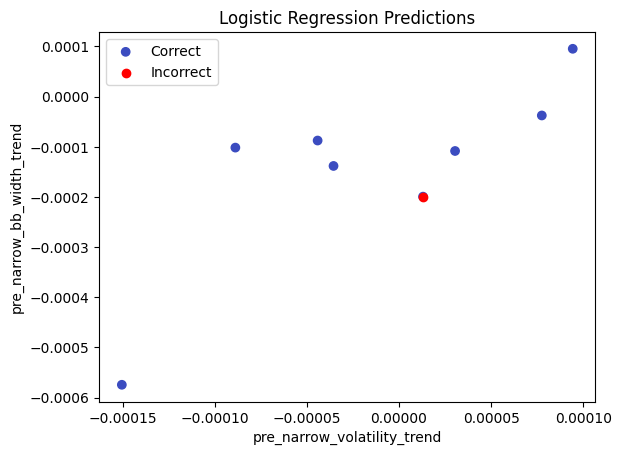

In [173]:
import matplotlib.pyplot as plt

# Plot the data points with different colors for correct and incorrect predictions
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=(y == model.predict(scaler.transform(X))), cmap='coolwarm', label='Correct')
plt.scatter(incorrect_data_point.iloc[:, 0], incorrect_data_point.iloc[:, 1], color='red', label='Incorrect')
plt.xlabel('pre_narrow_volatility_trend')
plt.ylabel('pre_narrow_bb_width_trend')
plt.title('Logistic Regression Predictions')
plt.legend()
plt.show()


In [175]:
# Assuming you have a new data point with the same features
new_data = pd.DataFrame({
    'pre_narrow_volatility_trend': [0.01],  # Replace with actual value
    'pre_narrow_bb_width_trend': [-0.005]   # Replace with actual value
})

# Standardize the new data using the same scaler
new_data_scaled = scaler.transform(new_data)

# Predict whether the new data point will be a narrow period
prediction = model.predict(new_data_scaled)

# Print the prediction
print("Will the next period be a narrow zone?:", prediction[0])


Will the next period be a narrow zone?: False


In [179]:
from sklearn.linear_model import LinearRegression

# Prepare the data
X = narrow_periods_df[['pre_narrow_volatility_trend', 'pre_narrow_bb_width_trend']]  # Features
y = narrow_periods_df['duration_days']  # Target: Duration in days

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Linear Regression model
reg_model = LinearRegression()
reg_model.fit(X_train_scaled, y_train)

# Predict the duration of the next narrow period
next_duration_prediction = reg_model.predict(scaler.transform(new_data))

print(f"Predicted duration of the next narrow period (in days): {next_duration_prediction[0]:.2f} days")


Predicted duration of the next narrow period (in days): 1954.55 days


In [180]:
# Calculate the average duration of previous narrow periods
average_duration_days = narrow_periods_df[narrow_periods_df['predicted_narrow_zone'] == True]['duration_days'].mean()

print(f"Estimated duration of the next narrow period (in days): {average_duration_days:.2f} days")

Estimated duration of the next narrow period (in days): 27.50 days
